In [1]:
from PyLQR.sim import KDLRobot
from PyLQR.system import PosOrnPlannerSys, PosOrnKeypoint
from PyLQR.solver import BatchILQRCP, ILQRRecursive
from PyLQR.utils import primitives, PythonCallbackMessage
import numpy as np

import matplotlib.pyplot as plt

# PyLQR: Position/Orientation planner or tracker with double integrator system example

In this example, we will present how to use iLQR to plan or track a system that has for target space $\mathbf{\mu}_t$ :

* position ``[x,y,z]``
* orientation (in quaternion) ``[w,x,y,z]``
* position velocity ``[dx,dy,dz]``
* Orientation velocity (in quaternion) ``[dw,dx,dy,dz]``

$$
    \mathbf{\mu}_t = \lbrack x \ y \ z \ w \ x \ y \ z \ dx \ dy \ dz \ dw \ dx \ dy \ dz \rbrack^\top
$$

For state space $\mathbf{x}_t$ (it is a latent space):

* joint positions $\mathbf{q}$
* joint velocities $\mathbf{\dot{q}}$

$$
    \mathbf{x}_t = \lbrack \mathbf{q}^\top \ \mathbf{\dot{q}}^\top \rbrack^\top
$$

For command space $\mathbf{u}_t$:

* joint accelerations $\mathbf{\ddot{q}}$

$$
    \mathbf{u}_t = \lbrack \mathbf{\ddot{q}}^\top \rbrack^\top
$$

<span style="color:red">**The target space is get with the forward kinematics function with $\mathbf{x}_t$  as robot configuration**</span>

In [2]:
# Global task variables
dof = 7
nb_deriv = 2
nb_state_var = nb_deriv * dof  # [q,dq]
nb_ctrl_var = dof  # [ddq]
nb_fox_var = nb_deriv * 7 # [pos,orn,dpos,dorn]
horizon=400
dt = 0.01

## Definition of the robot object

The first to do is to create the abstraction of the robot that we want to control. Here we will a robot's abstraction based on the KDL library. The ``KDLRobot`` class requires:

* An URDF file describing the robot that we want to use.
* The name of the base frame in the URDF
* The name of the tip frame in the URDF
* Initial joint configuration

This class will *simulate* the kinematics evolution of the Panda robot in function of the control command that we will send to him.

In [3]:
PATH_TO_URDF = "model.urdf"
BASE_FRAME = "panda_link0"
TIP_FRAME = "panda_tip"
q0 = [ 0.62991112, -0.2329776 , -0.01423721, -1.70254115,  0.06251303, # Initial joint configuration of the robot
        1.50592777,  0.71771416]
dq0 = [0]*dof

qMax = np.array([np.pi]*dof)*10
dqMax = np.array([10]*dof)
rbt = KDLRobot(PATH_TO_URDF,BASE_FRAME,TIP_FRAME,q0,dq0)

## Task & system definition

Now that we have an object simulating the kinematics of our robot, we have to build a system object that will describe the task that we want to perform. Here since we are looking to optimize position and orientation
we will instantiate an object of type ``PosOrnPlannerSys``. To create this object, we need:

* A list of Keypoints (here ``PosOrnKeypoint``), each element in this list represents a keypoint, it contains:
  * A position target
  * A linear velocity target
  * An orientation target
  * An angular velocity target
  * A precision matrix
  * A discrete time value (discrete time of occurence)
* Joint limits/special end-effector transforms. Optional (see below).
* Some extra-information about the system:
  * Control command penalty (rfactor)
  * Horizon of the problem
  * Order of the system (in this example it's 2)
  * The discrete time step (dt)

In [4]:
target1_pos = np.array([0.554121212377707,      #x (position)
            -0.01575049935289518,  #y (position)
            0.38295604872511507])   #z (position)

target1_orn = np.array([0.014042440828406944,  #w (quaternion)
            0.915047647731553,     #x (quaternion)
            0.4024820607528928,    #y (quaternion)
            0.022333898196169735])  #z (quaternion)

target1_vel = np.array([0, # dx (position)
                        0, # dy (position)
                        0]) # dz (position)

target1_vel_orn = np.array([0, # Angular velocity expressed in quaternion
                            0,
                            0,
                            0])

Qtarget1 = np.diag([1, # Tracking the x position
            1, # Tracking the y position
            1, # Tracking the z position
            .1, # Tracking orientation around x axis
            .1, # Tracking orientation around y axis
            .1, # Tracking orientation around z axis
            1, # Tracking the x velocity
            1, # Tracking the y velocity
            1, # Tracking the z velocity
            0, # Tracking orientation velocity around x axis
            0, # Tracking orientation velocity around y axis
            0]) # Tracking orientation velocity around z axis

target1_discrete_time = horizon//2 - 1

keypoint_1 = PosOrnKeypoint(target1_pos,target1_vel,target1_orn,target1_vel_orn,Qtarget1,target1_discrete_time)

# Similarly for the second target:
target2_pos = np.array([0.254121212377707,
            -0.07575049935289518,
            0.13170744424127526])

target2_orn = np.array([0.029927010072216945,
            0.9121514607332729,
            0.4087591864532181,
            0.00011933313484481926])

target2_vel = np.array([0, # dx (position)
                        0, # dy (position)
                        0]) # dz (position)

target2_vel_orn = np.array([0, # Angular velocity expressed in quaternion
                            0,
                            0,
                            0])

Qtarget2 = np.diag([1, # Tracking the x position
            1, # Tracking the y position
            1, # Tracking the z position
            .1, # Tracking orientation around x axis
            .1, # Tracking orientation around y axis
            .1, # Tracking orientation around z axis
            1, # Tracking the x velocity
            1, # Tracking the y velocity
            1, # Tracking the z velocity
            .1, # Tracking orientation velocity around x axis
            .1, # Tracking orientation velocity around y axis
            .1]) # Tracking orientation velocity around z axis

target2_discrete_time = horizon - 1

keypoint_2 = PosOrnKeypoint(target2_pos,target2_vel,target2_orn,target2_vel_orn,Qtarget2,target2_discrete_time)

cmd_penalties = (np.ones(nb_ctrl_var)*1e-5).tolist() # Each control signals have a penalty of 1e-5

keypoints = [keypoint_1,keypoint_2]

# It is not mandatory to set the limits, if you do not know them yet or do not want to use them. You can use this constructor:
# sys = PosOrnPlannerSys(rbt,keypoints,cmd_penalties,horizon,2,dt)
sys = PosOrnPlannerSys(rbt,keypoints,cmd_penalties,qMax,-qMax,dqMax,-dqMax,horizon,2,dt) 

## Solver definition

Now that the robot and system object are defined, we will define two different solvers to optimize the system:

* A Batch Iterative LQR with control primitives.
* A standard iLQR

Because of the batch formulation, the first one can only be used as a planning algorithm. 
Seconde one can either be used as planning or tracking algorithm (by using either the resulting state sequences or the control gains).

Batch solution use a library of primitives to build the control command:

$$
    \mathbf{u} = \Psi \mathbf{w}
$$

Where $\mathbf{w}$ is the weight of each control primitives. To build the primitives, you can use the ``PyLQR.utils.primitives`` module.

In [5]:
u0_t = np.array([0]*(nb_ctrl_var))
u0 = np.tile(u0_t,horizon-1)

K = 2
psi = primitives.build_psi_sawtooth(horizon-1,K)
PSI = np.kron(psi,np.identity(nb_ctrl_var))

# For the batch solution, if you want to use of diagonal elements for Q or special construction of mu,
# you can override targets and precisions set in the system by replacing the 2 lines below by what you want.
# mu = sys.get_mu_vector()
# Q = sys.get_Q_matrix()

planner1 = BatchILQRCP(sys,PSI)
planner2 = ILQRRecursive(sys)

In [6]:
cb = PythonCallbackMessage() # callback to notify python code of the solver evolution

In [7]:
%%time
U1 = planner1.solve(10,u0,True,cb)
U1 = U1.reshape((horizon-1,nb_ctrl_var))
rbt.set_conf(q0,dq0,True)
X1 = np.zeros((horizon,nb_state_var))
F_X1 = np.zeros((horizon,nb_fox_var))

X1[0] = np.hstack(( rbt.get_q() , rbt.get_dq() ))
F_X1[0] = np.hstack((rbt.get_ee_pos(), rbt.get_ee_orn() , rbt.get_ee_vel() , rbt.get_ee_ang_vel_quat() ))

for i in range(horizon-1):
    ut = U1[i]
    
    rbt.send_acc(dt,ut,True)
    
    X1[i+1] = np.hstack(( rbt.get_q() , rbt.get_dq() ))
    F_X1[i+1] = np.hstack((rbt.get_ee_pos(), rbt.get_ee_orn() , rbt.get_ee_vel() , rbt.get_ee_ang_vel_quat() ))

Iteration 1, Cost: 0.506613, alpha= 1
Iteration 2, Cost: 0.22596, alpha= 1
Iteration 3, Cost: 0.0517259, alpha= 1
Iteration 4, Cost: 0.00781604, alpha= 1
Iteration 5, Cost: 0.00506304, alpha= 1
Iteration 6, Cost: 0.00497986, alpha= 1
Iteration 7, Cost: 0.00497643, alpha= 0.5
Iteration 8, Cost: 0.00497642, alpha= 0.000976562
CPU times: user 608 ms, sys: 14.9 ms, total: 623 ms
Wall time: 621 ms


In [8]:
%%time
X2,F_X2,U2,K2,k2 = planner2.solve(u0.reshape((-1,nb_ctrl_var)),15,True,True,cb)

Iteration 1, Cost: 0.217351, alpha= 1, time= 0.0056352
Iteration 2, Cost: 0.0514887, alpha= 1, time= 0.0059034
Iteration 3, Cost: 0.0027045, alpha= 1, time= 0.00567975
Iteration 4, Cost: 0.00201796, alpha= 1, time= 0.00564458
Iteration 5, Cost: 0.00202046, alpha= 0.000976562, time= 0.0246833
CPU times: user 48.1 ms, sys: 4.02 ms, total: 52.1 ms
Wall time: 51.5 ms


<IPython.core.display.Javascript object>


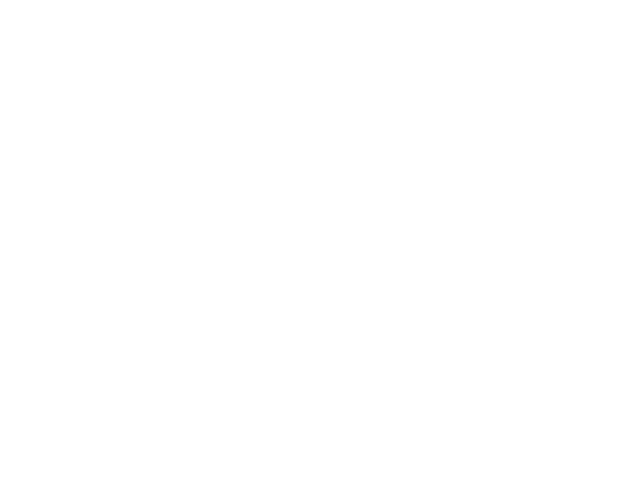

In [9]:
%matplotlib notebook
F_X2 = np.asarray(F_X2)

plt.figure()
plt.title('Position evolution (countinuous batch ilqr with CP / dashed standard iLQR)')
plt.plot(F_X1[:,0],c='r',label='x')
plt.plot(F_X1[:,1],c='g',label='y')
plt.plot(F_X1[:,2],c='b',label='z')

plt.plot(F_X2[:,0],c='r',linestyle='dashed')
plt.plot(F_X2[:,1],c='g',linestyle='dashed')
plt.plot(F_X2[:,2],c='b',linestyle='dashed')

plt.scatter(target1_discrete_time,target1_pos[0],c='r')
plt.scatter(target1_discrete_time,target1_pos[1],c='g')
plt.scatter(target1_discrete_time,target1_pos[2],c='b')

plt.scatter(target2_discrete_time,target2_pos[0],c='r')
plt.scatter(target2_discrete_time,target2_pos[1],c='g')
plt.scatter(target2_discrete_time,target2_pos[2],c='b')

plt.legend()

<IPython.core.display.Javascript object>


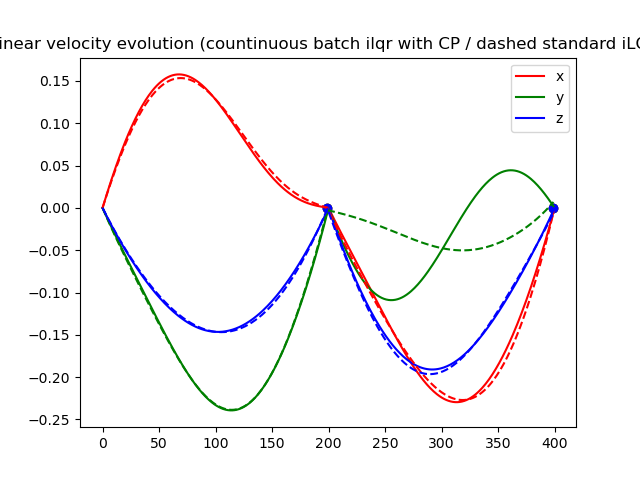

In [10]:
%matplotlib notebook
F_X2 = np.asarray(F_X2)

plt.figure()
plt.title('Linear velocity evolution (countinuous batch ilqr with CP / dashed standard iLQR)')
plt.plot(F_X1[:,7],c='r',label='x')
plt.plot(F_X1[:,8],c='g',label='y')
plt.plot(F_X1[:,9],c='b',label='z')

plt.plot(F_X2[:,7],c='r',linestyle='dashed')
plt.plot(F_X2[:,8],c='g',linestyle='dashed')
plt.plot(F_X2[:,9],c='b',linestyle='dashed')

plt.scatter(target1_discrete_time,target1_vel[0],c='r')
plt.scatter(target1_discrete_time,target1_vel[1],c='g')
plt.scatter(target1_discrete_time,target1_vel[2],c='b')

plt.scatter(target2_discrete_time,target2_vel[0],c='r')
plt.scatter(target2_discrete_time,target2_vel[1],c='g')
plt.scatter(target2_discrete_time,target2_vel[2],c='b')

plt.legend()

**As you can see, both solvers gave a good result, for this kind of example an advantage has to be given to the standard iLQR solver that performs much more faster than batch solution. The reason behind that is that time complexity evolves exponentially with horizon for the batch formulation. Also in this example we set the targets to uniformally spread the horizon (to not have problems with control primitives), but it is not mandatory if you are using the standard iLQR solution**